In [70]:

import os
import re
import json
import time
import sqlite3
from typing import List, Dict, Any, Optional

from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse
import re

from dotenv import load_dotenv
load_dotenv()

# LangChain / LangGraph imports
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
from langchain_groq import ChatGroq

True

In [2]:
SERPAPI_KEY = os.getenv("SERPAPI_KEY", "")
if not SERPAPI_KEY:
    raise RuntimeError("Set SERPAPI_KEY env var before running")

CHECKPOINT_DB = os.getenv("CHECKPOINT_DB", "./langgraph_checkpoints.db")
ALPHAVANTAGE_KEY = os.getenv("ALPHAVANTAGE_KEY", "BR1UI7DQQ6WKTV5N")  # keep original if present


In [3]:
def serp_search_news(query: str, num_results: int = 5) -> List[Dict[str, Any]]:
    
    
    url = "https://google.serper.dev/search"

    payload = {
        "q": query ,
        "tbs": "qdr:m"
    }
    headers = {
        'X-API-KEY': SERPAPI_KEY,
        'Content-Type': 'application/json'
    }

    response = requests.post(url, headers=headers, json=payload)

    # Parse and pretty print JSON
    data = response.json()
    res = []
    for i in data['organic']:
        res.append(i['link'])
    return res[0]

In [4]:
ssr= serp_search_news("Tata Steel latest news") 
    
    

In [5]:
ssr

'https://www.tatasteel.com/newsroom/press-releases/india/2025/tata-steel-board-affirms-the-long-term-strategy-for-growth-in-india/'

In [35]:
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (compatible; RiskAgent/1.0; +https://example.com/bot)'
}

def scrape_article_content(url: str, timeout: int = 10) -> Dict[str, Any]:
    try:
        domain = urlparse(url).netloc.lower()
        skip_domains = ['youtube.com', 'facebook.com', 'twitter.com', 'instagram.com', 'linkedin.com', 'reddit.com']
        if any(skip in domain for skip in skip_domains) or url.lower().endswith(".pdf"):
            return {"success": False, "reason": "Non-article domain"}

        resp = requests.get(url, headers=HEADERS, timeout=timeout)
        if resp.status_code != 200:
            return {"success": False, "reason": f"HTTP {resp.status_code}"}

        soup = BeautifulSoup(resp.content, "html.parser")
        for s in soup(["script", "style", "nav", "footer", "header"]):
            s.decompose()

        title = ""
        if soup.title:
            title = soup.title.get_text().strip()
        h1 = soup.find("h1")
        if h1 and len(h1.get_text().strip()) > len(title):
            title = h1.get_text().strip()

        article_selectors = [
            'article', '.article-content', '.post-content', '.entry-content',
            '.story-body', '.article-body', 'main'
        ]
        content = ""
        for sel in article_selectors:
            node = soup.select_one(sel)
            if node:
                ps = node.find_all("p")
                content = " ".join([p.get_text().strip() for p in ps if len(p.get_text().strip()) > 40])
                if len(content) > 200:
                    break

        if not content or len(content) < 200:
            ps = soup.find_all("p")
            content = " ".join([p.get_text().strip() for p in ps if len(p.get_text().strip()) > 40])

        content = re.sub(r'\s+', ' ', content).strip()
        if len(content) < 100:
            return {"success": False, "reason": "Content too short"}

        return {"content": content[:5000]}

    except Exception as e:
        return {"success": False, "reason": str(e)[:200]}


In [36]:
scrp = scrape_article_content('https://www.goodreturns.in/news/1-2-bonus-1-10-split-dividends-tatas-steel-stock-tata-steel-recommended-to-buy-highest-target-rs-210-1474999.html')

In [38]:
scrp['content']

'Tata Steel, the metals and mining flagship of Tata Group, has recorded more than 3.5% growth on BSE and NSE year-to-date. Metal stocks are in focus as COMEX copper rose nearly 3%, reaching a multi-month high. Amidst expectations of easing in bolstered sentiment across the industrial metals space, Tata Steel is among the top picks in the sector. The majority of analysts have recommended BUY with target prices ranging from Rs 200 to Rs 210. After market hours on December 5th, Tata Steel stood at Rs 167.10 apiece on BSE, with a market cap of Rs 2,08,723.16 crore. The stock is less than Rs 20 away from hitting its 52-week high of Rs 187. YTD, the stock is up by 3.53% on BSE. From its 52-week low of Rs 122.60 apiece, Tata Steel gained by more than 36% as of now. Tata Steel has rewarded investors with a hefty dividend and is among top dividend yield stock in the sector. It has also carried one stock split and bonus issue in its history so far. The first time Tata Steel rewarded investors wi

In [9]:
@tool
def serp_tool(query: str, num_results: int = 5) -> Dict[str, Any]:
    """Tool does google search and shows the single most relevant search for the query."""
    try:
        results = serp_search_news(query, num_results=num_results)
        return {"success": True, "results": results}
    except Exception as e:
        return {"success": False, "error": str(e)}

@tool
def scrape_tool(url: str) -> Dict[str, Any]:
    """Tool scrapes the content accurately of the provided link and this data can be used by the LLM for risk scoring the company."""
    try:
        res = scrape_article_content(url)
        return res
    except Exception as e:
        return {"success": False, "error": str(e)}
    
    


In [71]:
import requests

# -------------------------------
# 1. SETUP
# -------------------------------
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY", "")
if not WEATHER_API_KEY:
    raise RuntimeError("Set WEATHER_API_KEY env var before running")# Replace with your actual key
BASE_URL = "http://api.weatherapi.com/v1"


# -------------------------------
# 2. FUNCTION - Get Current Weather
# -------------------------------
def get_current_weather(city):
    """
    Fetches current weather from WeatherAPI
    """
    endpoint = f"{BASE_URL}/current.json"
    
    # Parameters sent to the API
    params = {
        "key": WEATHER_API_KEY,
        "q": city,          # q = query (city name, lat/lon, postal code, etc.)
        "aqi": "yes"        # include air quality index
    }

    response = requests.get(endpoint, params=params)
    data = response.json()
    return data


# -------------------------------
# 3. FUNCTION - Get Forecast
# -------------------------------
def get_forecast(city, days=3):
    """
    Fetches forecast for the next X days (max: 14 days in free plan)
    """
    endpoint = f"{BASE_URL}/forecast.json"
    
    params = {
        "key": API_KEY,
        "q": city,
        "days": days,
        "aqi": "yes",
        "alerts": "yes"      # shows storm / weather alerts
    }

    response = requests.get(endpoint, params=params)
    data = response.json()
    return data


# -------------------------------
# 4. USING THE FUNCTIONS
# -------------------------------
city_name = "New York"

# Get current weather
current_weather = get_current_weather(city_name)
print("----- CURRENT WEATHER -----")
print(current_weather)

# Get forecast (next 3 days)
forecast_data = get_forecast(city_name, days=3)
print("----- FORECAST -----")
print(forecast_data)


----- CURRENT WEATHER -----
{'location': {'name': 'New York', 'region': 'New York', 'country': 'United States of America', 'lat': 40.7142, 'lon': -74.0064, 'tz_id': 'America/New_York', 'localtime_epoch': 1765622075, 'localtime': '2025-12-13 05:34'}, 'current': {'last_updated_epoch': 1765621800, 'last_updated': '2025-12-13 05:30', 'temp_c': -2.2, 'temp_f': 28.0, 'is_day': 0, 'condition': {'text': 'Clear', 'icon': '//cdn.weatherapi.com/weather/64x64/night/113.png', 'code': 1000}, 'wind_mph': 5.6, 'wind_kph': 9.0, 'wind_degree': 237, 'wind_dir': 'WSW', 'pressure_mb': 1021.0, 'pressure_in': 30.14, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 58, 'cloud': 0, 'feelslike_c': -5.7, 'feelslike_f': 21.8, 'windchill_c': -6.1, 'windchill_f': 21.0, 'heatindex_c': -2.1, 'heatindex_f': 28.2, 'dewpoint_c': -8.1, 'dewpoint_f': 17.5, 'vis_km': 16.0, 'vis_miles': 9.0, 'uv': 0.0, 'gust_mph': 8.1, 'gust_kph': 13.1, 'air_quality': {'co': 417.85, 'no2': 58.25, 'o3': 6.0, 'so2': 16.65, 'pm2_5': 22.95, 'pm1

In [40]:
print(len(forecast_data['forecast']))

1


In [41]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [72]:
print(forecast_data['forecast']['forecastday'][0]['day'])
for j in range(0,3):
    for i in range(0,24,5):
        print("time:",forecast_data['forecast']['forecastday'][j]['hour'][i]['time'],"condition:",forecast_data['forecast']['forecastday'][0]['hour'][i]['condition']['text'],"temp_c:",forecast_data['forecast']['forecastday'][0]['hour'][0]['temp_c'])

print(forecast_data['forecast']['forecastday'][0]['date'])
print(forecast_data['forecast']['forecastday'][0]['hour'][0]["time"])


{'maxtemp_c': 6.7, 'maxtemp_f': 44.1, 'mintemp_c': -2.4, 'mintemp_f': 27.7, 'avgtemp_c': 1.0, 'avgtemp_f': 33.8, 'maxwind_mph': 10.7, 'maxwind_kph': 17.3, 'totalprecip_mm': 0.0, 'totalprecip_in': 0.0, 'totalsnow_cm': 0.0, 'avgvis_km': 9.8, 'avgvis_miles': 6.0, 'avghumidity': 69, 'daily_will_it_rain': 0, 'daily_chance_of_rain': 0, 'daily_will_it_snow': 0, 'daily_chance_of_snow': 0, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'uv': 0.2, 'air_quality': {'co': 336.17000000000013, 'no2': 51.114000000000004, 'o3': 15.8, 'so2': 12.341999999999999, 'pm2_5': 17.158, 'pm10': 17.422, 'us-epa-index': 2, 'gb-defra-index': 2}}
time: 2025-12-13 00:00 condition: Clear  temp_c: -1.2
time: 2025-12-13 05:00 condition: Clear  temp_c: -1.2
time: 2025-12-13 10:00 condition: Sunny temp_c: -1.2
time: 2025-12-13 15:00 condition: Sunny temp_c: -1.2
time: 2025-12-13 20:00 condition: Overcast  temp_c: -1.2
time: 2025-12-14 00:00 condition: Clear  temp_c:

In [73]:
@tool 
def weather_summary(city_name:str):
    """This tools helps in gathering the weather summary of the city and also provides the forecast of the next 3 days"""
    # Get forecast (next 3 days)
    forecast_data = get_forecast(city_name, days=3)
    result = []
    for j in range(0,3):
        for i in range(0,24,5):
            result.append(["time:",forecast_data['forecast']['forecastday'][j]['hour'][i]['time'],"condition:",forecast_data['forecast']['forecastday'][0]['hour'][i]['condition']['text'],"temp_c:",forecast_data['forecast']['forecastday'][0]['hour'][0]['temp_c']])

    return result

In [74]:
output = weather_summary("New York")
output

[['time:', '2025-12-13 00:00', 'condition:', 'Clear ', 'temp_c:', -1.2],
 ['time:', '2025-12-13 05:00', 'condition:', 'Clear ', 'temp_c:', -1.2],
 ['time:', '2025-12-13 10:00', 'condition:', 'Sunny', 'temp_c:', -1.2],
 ['time:', '2025-12-13 15:00', 'condition:', 'Sunny', 'temp_c:', -1.2],
 ['time:', '2025-12-13 20:00', 'condition:', 'Overcast ', 'temp_c:', -1.2],
 ['time:', '2025-12-14 00:00', 'condition:', 'Clear ', 'temp_c:', -1.2],
 ['time:', '2025-12-14 05:00', 'condition:', 'Clear ', 'temp_c:', -1.2],
 ['time:', '2025-12-14 10:00', 'condition:', 'Sunny', 'temp_c:', -1.2],
 ['time:', '2025-12-14 15:00', 'condition:', 'Sunny', 'temp_c:', -1.2],
 ['time:', '2025-12-14 20:00', 'condition:', 'Overcast ', 'temp_c:', -1.2],
 ['time:', '2025-12-15 00:00', 'condition:', 'Clear ', 'temp_c:', -1.2],
 ['time:', '2025-12-15 05:00', 'condition:', 'Clear ', 'temp_c:', -1.2],
 ['time:', '2025-12-15 10:00', 'condition:', 'Sunny', 'temp_c:', -1.2],
 ['time:', '2025-12-15 15:00', 'condition:', 'Sunn

In [75]:



# Tools list that LLM can choose from
TOOLS = [serp_tool, scrape_tool, weather_summary]

In [76]:
# LLM instance (Gemini)
llm = ChatGroq(temperature=0.6, model="moonshotai/kimi-k2-instruct-0905")
llm_bound = llm.bind_tools(TOOLS) 

In [77]:
llm_bound.invoke('What is latest news about tatasteel?')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'functions.serp_tool:0', 'function': {'arguments': '{"num_results":5,"query":"latest news about Tata Steel"}', 'name': 'serp_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 275, 'total_tokens': 304, 'completion_time': 0.101984684, 'completion_tokens_details': None, 'prompt_time': 0.009210137, 'prompt_tokens_details': {'cached_tokens': 256}, 'queue_time': 0.285756972, 'total_time': 0.111194821}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_3312304636', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--08ed0676-46cb-4754-b612-63f25d311705-0', tool_calls=[{'name': 'serp_tool', 'args': {'num_results': 5, 'query': 'latest news about Tata Steel'}, 'id': 'functions.serp_tool:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 275, 'output_tokens': 29, 'total_tokens': 304})

In [78]:
llm_bound.invoke('{"message": "you are a helpful assitant, your task is to find the latest information about tatasteel and give them a risk score so that i can decide whether to buy from them or not and the risk score will be given on the basis of whether the news is good or not. you are also provided with tools that you can use to find the link and then scrape the info , which you can use to give a risk_score to the company , if bad_news = high score else low score "}' )

AIMessage(content="I'll help you analyze Tata Steel's latest information and provide a risk score. Let me gather the most recent news about Tata Steel.", additional_kwargs={'tool_calls': [{'id': 'functions.serp_tool:0', 'function': {'arguments': '{"query":"Tata Steel latest news 2024 financial performance stock price"}', 'name': 'serp_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 369, 'total_tokens': 424, 'completion_time': 0.226963955, 'completion_tokens_details': None, 'prompt_time': 0.016133017, 'prompt_tokens_details': {'cached_tokens': 256}, 'queue_time': 0.286860721, 'total_time': 0.243096972}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_3312304636', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--559d5957-917a-463e-9517-e9c937438e00-0', tool_calls=[{'name': 'serp_tool', 'args': {'query': 'Tata Steel latest news 2024 financial performance stock pri

In [79]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage] ,  add_messages]


In [80]:
def chat_node(state:ChatState):
    """
    LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_bound.invoke(messages)
    return {'messages':[response]}

tool_node = ToolNode(TOOLS)
  

In [81]:
  
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)


In [82]:
graph.add_edge(START, "chat_node")
graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge('tools', 'chat_node')  



In [83]:
chatbot = graph.compile()

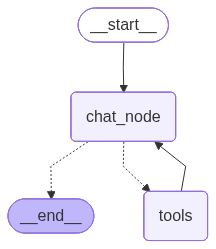

In [84]:
chatbot

In [85]:
logistic_agent = {'supplier': 'JAMSHEDPUR_TATA', 'project_site': 'NAGPUR_SITE', 
 'quantity_tonnes': 1500.0, 'road_distance_km': 983.28, 
 'ETA_days': 4, 'estimated_arrival_date': '2025-12-15', 
 'transport_cost_inr': 9587005.0}

price_agent = {"grand_total":"51 cr"}


company_name = logistic_agent['supplier']
price_agent_info = price_agent['grand_total']
print(company_name, price_agent_info)
logistic_agent_info = str(logistic_agent)
print(logistic_agent_info)


JAMSHEDPUR_TATA 51 cr
{'supplier': 'JAMSHEDPUR_TATA', 'project_site': 'NAGPUR_SITE', 'quantity_tonnes': 1500.0, 'road_distance_km': 983.28, 'ETA_days': 4, 'estimated_arrival_date': '2025-12-15', 'transport_cost_inr': 9587005.0}


In [104]:
out = chatbot.invoke({'messages':[HumanMessage(content=f"""You are the RISK SCORING AGENT.

Your purpose:
Given:
- Company names,
- Price Agent data,
- Logistics Agent data (distance, delivery time, region, transport duration),
- Weather Summary Tool results for supplier regions,
- Web news about the company's supplier performance,

You must compute a final RISK SCORE for each company.

---------------------------------------------------------
DEFINITIONS (CRITICAL — FOLLOW EXACTLY)
---------------------------------------------------------

Tool Execution Success:
- A tool is considered SUCCESSFUL if it returns ANY output without throwing an error.
- Low relevance, short text, or neutral content is NOT a failure.

Tool Execution Failure:
- Tool raises an error
- Tool returns NOTHING (null / empty response)

Content Quality is NOT a failure condition.

---------------------------------------------------------
YOUR WORKFLOW (STRICT, LINEAR, NO LOOPS)
---------------------------------------------------------

For each company, FOLLOW THIS ORDER EXACTLY ONCE:

### STEP 1 — Fetch Supplier-Relevant News
Use ONLY "serp_tool" to fetch exactly ONE URL.

Search query MUST include:
- company name
- supplier OR supply chain OR raw material OR manufacturing

MUST:
- Use serp_tool exactly once per company
- Accept the URL even if relevance seems weak
- NEVER retry or reformulate the query

If serp_tool fails → mark status = "unable_to_fetch" and jump to STEP 7.

---

### STEP 2 — Scrape Article Content
Use ONLY "scrape_tool" on the obtained URL.

Rules:
- If scrape_tool returns ANY text → treat as SUCCESS
- Do NOT judge quality or length
- Do NOT retry

If scrape_tool fails → mark status = "unable_to_fetch" and jump to STEP 7.

---

### STEP 3 — Interpret Supplier Risk Sentiment
Based ONLY on scraped text, classify supplier-side sentiment:

- "good" → strong reliability / stability
- "neutral" → mixed, unclear, or informational
- "bad" → disruptions, delays, financial stress

If text is vague or weak → classify as "neutral" (NOT failure).

---

### STEP 4 — Weather-Based Risk Adjustment (Low Influence)
Use Weather Summary Tool output from Logistics Agent.

Rules:
- Severe events (storm, flood, snow) → +1 risk
- Mild / normal → +0.2 risk
- Weather influence capped at 10%

Weather can NEVER cause unable_to_fetch.

---

### STEP 5 — Combine All Agent Signals (Weighted)
Apply weights strictly:

- Supplier News Sentiment → 50%
- Logistics Agent Info → 25%
- Price Agent Info → 15%
- Weather Impact → 10%

---

### STEP 6 — Final Risk Score (1–10)
Rules:
- Bad news → base 8–10
- Neutral → base 4–7
- Good → base 1–3

Adjust using weighted inputs above.

---

### STEP 7 — Output JSON (Per Company)
Return exactly one JSON object:


  "company": "<company_name>",
  "news_status": "good | neutral | bad | unable_to_fetch",
  "risk_score": "<1–10 or null>",
  "reason": "<one concise explanation>"


If status is "unable_to_fetch":
- risk_score MUST be null
- reason MUST explain which tool failed

---------------------------------------------------------
GLOBAL HARD RULES (DO NOT VIOLATE)
---------------------------------------------------------
- No retries
- No loops
- No tool repetition
- No browser tools
- Process companies sequentially
- NEVER self-trigger additional attempts
- If tools succeed, NEVER return unable_to_fetch
- Keep reasoning internal
- Output ONLY final JSON list

---------------------------------------------------------
User Input:
COMPANIES: {company_name}
logistic_agent_info: {logistic_agent_info}
price_agent_info: {price_agent_info}

Follow all rules exactly.

""") ]})


In [105]:
out

{'messages': [HumanMessage(content='You are the RISK SCORING AGENT.\n\nYour purpose:\nGiven:\n- Company names,\n- Price Agent data,\n- Logistics Agent data (distance, delivery time, region, transport duration),\n- Weather Summary Tool results for supplier regions,\n- Web news about the company\'s supplier performance,\n\nYou must compute a final RISK SCORE for each company.\n\n---------------------------------------------------------\nDEFINITIONS (CRITICAL — FOLLOW EXACTLY)\n---------------------------------------------------------\n\nTool Execution Success:\n- A tool is considered SUCCESSFUL if it returns ANY output without throwing an error.\n- Low relevance, short text, or neutral content is NOT a failure.\n\nTool Execution Failure:\n- Tool raises an error\n- Tool returns NOTHING (null / empty response)\n\nContent Quality is NOT a failure condition.\n\n---------------------------------------------------------\nYOUR WORKFLOW (STRICT, LINEAR, NO LOOPS)\n-------------------------------